One of the major unsolved problems in earthquake science and seismic hazard is understanding why earthquakes in a region seem to be 'clustered' in both time and space. The recent (and possibly ongoing) [sequence of earthquakes in central Italy][c-it-seq] is an example of this: Given the long (hundreds to thousands of years) time between earthquakes on each individual fault, it is highly improbable that these faults would *independently* rupture within a few years of each other. (Note that we are not discussing aftershocks here, but similarly-sized earthquakes on different faults).

The implication, therefore, is that the earthquakes are either A) triggering one another, or B) responding to some larger signal. We don't have any indication that B happened in Italy; there was no larger regional or global burst in seismicity that might give evidence of this, or any known anomalous geophysical activity.

It's more reasonable to consider that the first earthquake may have perturbed the other faults enough to cause them to rupture shortly thereafter. After several decades of research into this phenomenon, the tectonics and seismological community generally recognizes that 'coseismic stress changes' can induce seismicity on other faults. Coseismic stress changes are modifications of the balance of forces promoting and resisting earthquakes on faults, caused by deformation of the crust during and after an earthquake.  These are typically calculated in terms of the [Coulomb stress change][csc], which is the change in shear stress promoting fault slip minus the change in frictional strength resisting slip.

Coulomb stress changes are frequently shown to correlate with seismicity following an earthquake, and it makes sense theoretically that increasing the forces promoting fault slip or decreasing the resistance (or both) should promote earthquakes. However, Coulomb stress changes are typically very small relative to the stress released during an earthquake (often 0.1% to 1%), so it's not at all clear how they could be a significant trigger of earthquakes.

Earthquakes in general are a fairly difficult topic to study. They are brief and unplanned, making them hard to capture. They start thousands of meters underneath the surface, and may not reach the surface at all, making direct observation difficult. They don't last long and they're incredibly violent, so when they do hit you're better off running for cover than grabbing your camera. So understanding the conditions under which a small perturbation like a coseismic stress change can drastically affect a much larger system can hopefully tell us a lot about the system that we can't infer directly.

In this blog post, we'll explore some ideas about earthquake triggering using simple mathematical models to try and replicate some of the basic observations of earthquake clustering. If we're successful, we'll have learned a bit about earthquakes, and in the future we'll work on further clarifying the physics of the process, as well as demonstrating how earthquake clustering and related phenomena affect societal risk and vulnerability.  This is the GEM Foundation, after all.

[c-it-seq]: https://www.emsc-csem.org/Earthquake/250/M6-1-CENTRAL-ITALY-on-October-26th-2016-at-19-18-UTC

[csc]: https://en.wikipedia.org/wiki/Coulomb_stress_transfer

### Stress and the earthquake cycle

Faults go through a cyclic process of loading (in which shear stress accumulates on the fault) and unloading (in which shear stress is released during an earthquake), which is often referred to as 'the earthquake cycle'. The loading portion of the cycle is very slow, hundreds to tens of thousands of years, while the earthquakes last seconds.

Because we don't have a lot of evidence for tectonic plates speeding up and slowing down over earthquake cycle timescales, it's often assumed that the increase in stress (due to plate tectonic processes loading the faults) is linear. This has lead to a view of the earthquake cycle that looks like this, which we'll call the 'sawtooth pattern':

![sawtooth earthquake cycle]({static}/images/2017/eq_cycle_sawtooth.png)

However, there is a problem with this simple model of the earthquake cycle. As pointed out by several researchers (including [Gomberg et al. (1998)][gb98] and [Scholz (2010)][s10]), if the 'phase' of the earthquake cycle (shear stress divided by frictional strength) increases linearly, then the an earthquake can only trigger another earthquake via a small coseismic perturbation (say 1% of the total stress cycle) if the second fault is already >99% of the way through its cycle. This is inconsistent with evidence of earthquake clusters on faults with very different recurrence intervals, for example faults around Seattle, Washington ([Sherrod and Gomberg, 2014][sg14]).

However, decades-old research into the synchronization of oscillating systems (such as pendulum clocks and fireflies) has determined that if the loading portion of the cycle is nonlinear, and in particular faster in the beginning or middle than the end, then synchronization of oscillators is possible. But in the case of earthquakes, where does the nonlinearity come from?

Gomberg et al. (1998) suggest that the frictional strength of faults changes throughout the earthquake cycle. This is possible and supported by laboratory friction experiments which show that faults strengthen with time after failure.

Scholz (2010), on the other hand, suggests that the stress loading on the fault is nonlinear due to viscoelastic relaxation in the lower crust and upper mantle below the faults, and that this effect is much larger than time-dependent changes in frictional strength.

[gb98]: http://onlinelibrary.wiley.com/doi/10.1029/98JB01125/full
[s10]: http://www.bssaonline.org/content/100/3/901.full.pdf
[sg14]: http://onlinelibrary.wiley.com/doi/10.1002/2013JB010635/full

## Simulating fault interaction and clustering

In this post, we will make some models of faults that interact over the earthquake cycle. We'll look at the effects of fault reloading, and of how differences in earthquake recurrence intervals on interacting faults affect the amount of clustering.

We will keep the models pretty basic at this point, and not bring in much realistic geophyics. In the future, once we know a little better what to focus on, we can start bringing in more complexities and realism.  For now, though, we'll keep it simple.

Please note that this post is done in a [Jupyter notebook](http://jupyter.org/) and can be [downloaded](https://gist.github.com/cossatot/6a40bfd167846e3b3b12b42a1e3aacac#file-eq-clustering-notebook-ipynb) and executed on your computer if you have the basic scientific Python packages.

First, let's import the important modules.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Now, we're going to make a simple `Fault` class that does a couple of things. It has some intrinsic characteristics (the recurrence interval), and some changing characteristics (the `phase` of the fault, or where it is in the earthquake cycle). The fault loads progressively with time, either linearly or nonlinearly, and when the phase reaches about 1 (there is some randomness; it is the earth after all), an earthquake occurs and the phase drops down to zero.  When the earthquake occurs, it sends a little push of 0.01 phase units to other faults.

In [3]:
class Fault(object):
    def __init__(self, nat_rec_int, n_yrs=int(1e5), start_phase=0., other_faults=list()):
        self.phase = start_phase
        self.phase_time_series = np.zeros(n_yrs)
        self.phase_max = 1.
        self.eq_list = []
        self.nat_rec_int = nat_rec_int
        self.dp = 1 / self.nat_rec_int
        self.other_faults = [other_faults]
        self.load_constant = 5 / self.nat_rec_int
        self.elapsed_time = 0.
        
    def linear_advance(self, year):
        self.phase += self.dp
        self.phase_time_series[year] = self.phase
        
        if self.phase > self.phase_max:
            self.earthquake(year)
            self.phase_max = 1 + np.random.normal() * 0.05
            
    def nonlinear_advance(self, year):
        self.phase += nl_load(self.elapsed_time, self.nat_rec_int) 
        self.phase_time_series[year] = self.phase
        
        self.elapsed_time += 1.
        
        if self.phase > self.phase_max:
            self.earthquake(year)
            self.phase_max = 1 + np.random.normal() * 0.05
            
    def eq_advance(self, year, push=0.01):
        self.phase += push
        
        if self.phase > 1:
            self.earthquake(year)
        
    def earthquake(self, year):
        self.eq_list.append(year)
        
        self.elapsed_time = 0.
        self.phase = 0.
        
        if len(self.other_faults) > 0:
            for fault in self.other_faults:
                fault.eq_advance(year)
                
                
def nl_load(elapsed_time, nat_rec=100):
    load_const = 5 / nat_rec
    lin_load = 1 / nat_rec
    
    nl = 2/3 * load_const * np.exp(-load_const * elapsed_time)
    lin = 1/3 * lin_load
    
    return nl + lin

(Hopefully that wasn't too bad, the code is self-explanatory, and the lack of comments doesn't bother you. Sorry! But right now I just want to focus on the science, not the code.)

### Linear fault reloading

Our first experiment will be looking at two faults that load linearly, and have somewhat different recurrence intervals (400 and 700 years, respectively). Other than the recurrence intervals, they're identical.

When each fault ruptures, it affects the other one, pushing its phase forward by 0.01.

Let's simulate 1,000,000 years of the earthquake cycle:

In [4]:
# experiment setup

n_yrs = int(1e6)
yrs = np.arange(n_yrs, dtype=int)

fault1 = Fault(400, n_yrs=n_yrs)
fault2 = Fault(700, n_yrs=n_yrs)

fault1.other_faults = [fault2]
fault2.other_faults = [fault1]

In [5]:
# Now start the clock

for yr in yrs:
    fault1.linear_advance(yr)
    fault2.linear_advance(yr)

Now let's look at part of the history:

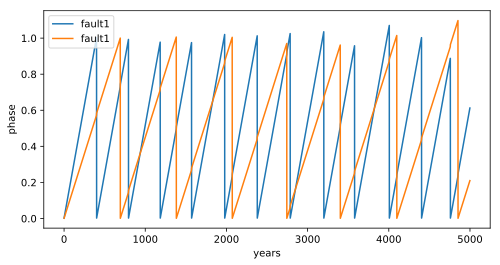

In [6]:
plt.figure(figsize=(8,4))

plt.plot(yrs[:5000], fault1.phase_time_series[:5000], 
         label='fault1')
plt.plot(yrs[:5000], fault2.phase_time_series[:5000], 
         label='fault1')

plt.legend(loc='best')

plt.xlabel('years')
plt.ylabel('phase')

plt.show()

So it looks like the earthquakes overlap a little bit, sometimes, but in general it doesn't look like the faults have a dramatic effect on one another.

One way to tell is to look at the time difference between the events; if there is a high frequency of small times between events, this is a sign of clustering.

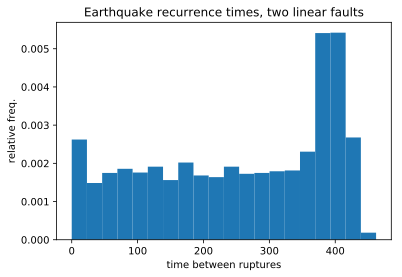

In [7]:
plt.hist(np.diff(np.sort(fault1.eq_list + fault2.eq_list)), 
         bins=20, normed=True)

plt.xlabel('time between ruptures')
plt.ylabel('relative freq.')

plt.title('Earthquake recurrence times, two linear faults')

plt.show()

Well, that's not very promising for the linear loading model.


### Nonlinear fault reloading

Let's try a nonlinear loading pattern and see what happens.  Here is the nonlinear loading function; it's 1/3 linear (representing tectonic stress increase throughout the crust, which is probably linear) and 2/3 nonlinear (exponentially-decreasing), representing viscoelastic relaxation of the lower crust and upper mantle. (This is not meant to accurately represent the physics involved--we'll save that for a later post.)

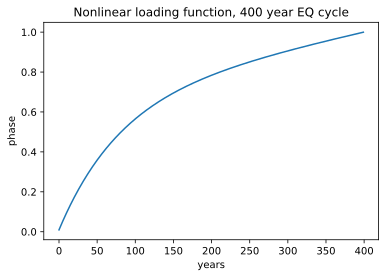

In [8]:
cycle_len = 400
cycle = np.arange(cycle_len)

plt.plot(cycle, np.cumsum(nl_load(cycle, cycle_len)))

plt.xlabel('years')
plt.ylabel('phase')
plt.title('Nonlinear loading function, 400 year EQ cycle')

plt.show()

Ok, so let's run the experiment again, changing only the loading functions of the fault:

In [9]:
n_yrs = int(1e6)
yrs = np.arange(n_yrs, dtype=int)

fault3 = Fault(400, n_yrs=n_yrs)
fault4 = Fault(700, n_yrs=n_yrs)

fault3.other_faults = [fault4]
fault4.other_faults = [fault3]

In [10]:
for yr in yrs:
    fault3.nonlinear_advance(yr)
    fault4.nonlinear_advance(yr)

Now let's look at the beginning of the time series.  Fault 3 is on top, Fault 4 is on bottom.  When Fault 3 has an earthquake, it's a red line Fault 4's time series, and vice versa.

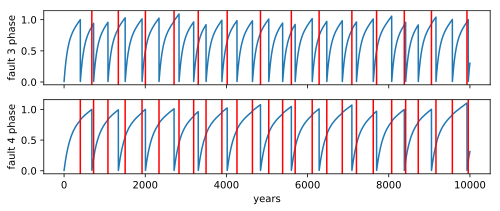

In [11]:
f, (ax0, ax1) = plt.subplots(2, sharex=True, figsize=(8,3))

yr_lim = 10000

ax0.plot(yrs[:yr_lim], fault3.phase_time_series[:yr_lim])
ax0.set_ylabel('fault 3 phase')
for eq in fault4.eq_list:
    if eq < yr_lim:
        ax0.axvline(eq, color='r')
                             
ax1.plot(yrs[:yr_lim], fault4.phase_time_series[:yr_lim])
ax1.set_ylabel('fault 4 phase')
for eq in fault3.eq_list:
    if eq < yr_lim:
        ax1.axvline(eq, color='r')                            
        
plt.xlabel('years')
plt.show()

It looks like the earthquakes coincide a bit more here.  Again, let's look at a histogram of the time between earthquakes and see if there is a spike at very low values:

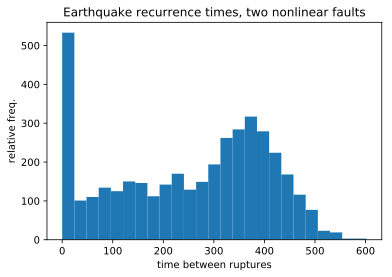

In [12]:
plt.hist(np.diff(np.sort(fault3.eq_list + fault4.eq_list)), bins=25)

plt.xlabel('time between ruptures')
plt.ylabel('relative freq.')

plt.title('Earthquake recurrence times, two nonlinear faults')

plt.show()

That's pretty dramatic; we're definitely seeing clusters. I think that this is particularly impressive given that the faults only change each others' phase *by 1%*.

One of the interesting things about this type of interaction between oscillating objects is that given nonlinear reloading and *relatively* similar oscillation periods (earthquake recurrence intervals in this case), they should progressively become more synchronized with time. This means that it's not super important how out of phase they were in the beginning, sync will eventually occur.

Let's look at the end of the time series we just ran and see if the faults appear more synchronized:

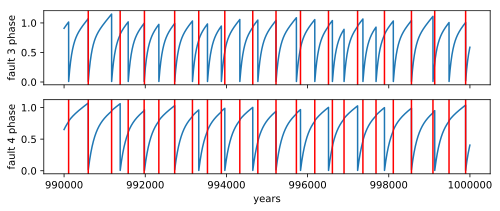

In [13]:
f, (ax0, ax1) = plt.subplots(2, sharex=True, figsize=(8,3))

yr_lim = 10000

ax0.plot(yrs[-yr_lim:], fault3.phase_time_series[-yr_lim:])
ax0.set_ylabel('fault 3 phase')
for eq in fault4.eq_list:
    if eq > (1e6 - yr_lim):
        ax0.axvline(eq, color='r')
                             
ax1.plot(yrs[-yr_lim:], fault4.phase_time_series[-yr_lim:])
ax1.set_ylabel('fault 4 phase')
for eq in fault3.eq_list:
    #if eq < yr_lim:
    if eq > (1e6 - yr_lim):
        ax1.axvline(eq, color='r')                            
        
plt.xlabel('years')
plt.show()

And indeed they do, at least at a simple glance.

### Effects of recurrence intervals

The existing literature on the topic (both by Scholz and by the mathematicians and statistical physicists who developed these concepts in the late 20th century) is largely concerned with more or less perfect synchronization. In this blog post, I've only been seeking to reproduce earthquake clusters some of the time, rather than all the time.

However, even with very different slip rates (400 and 700 years) we saw that the two faults in the last experiment became more synchronized with time.  The research on the topic suggests that, all else equal, oscillators with more similar periods (i.e. faults with more similar recurrence intervals) will have an easier time becoming synchronized.

Let's adjust the recurrence intervals a bit and see what happens.  Now we have faults with a 10% different recurrence interval:

In [14]:
fault5 = Fault(500, n_yrs=n_yrs)
fault6 = Fault(550, n_yrs=n_yrs)

fault5.other_faults = [fault6]
fault6.other_faults = [fault5]

In [15]:
for yr in yrs:
    fault5.nonlinear_advance(yr)
    fault6.nonlinear_advance(yr)

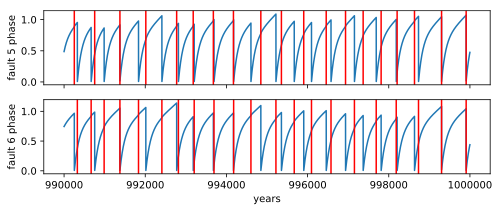

In [16]:
f, (ax0, ax1) = plt.subplots(2, sharex=True, figsize=(8,3))

yr_lim = 10000

ax0.plot(yrs[-yr_lim:], fault5.phase_time_series[-yr_lim:])
ax0.set_ylabel('fault 5 phase')
for eq in fault6.eq_list:
    if eq > (1e6 - yr_lim):
        ax0.axvline(eq, color='r')
                             
ax1.plot(yrs[-yr_lim:], fault6.phase_time_series[-yr_lim:])
ax1.set_ylabel('fault 6 phase')
for eq in fault5.eq_list:
    #if eq < yr_lim:
    if eq > (1e6 - yr_lim):
        ax1.axvline(eq, color='r')                            
        
plt.xlabel('years')
plt.show()

Well, this is definitely far more synchronization that we've seen, but it's still not perfect. I'm going to claim this is because of the randomness involved in the earthquake threshold (it's not perfectly 1), but I'm not sure. Maybe in the future I will investigate.

### More faults

For our last experiment, let's look to see what happens with more faults, of very different recurrence intervals.  This more accurately characterizes many regions, as earthquakes tend to occur on a few highly active faults and the other regional faults are subsidiary. These systems often display clusters as well.

In [17]:
fault01 = Fault(1000, n_yrs=n_yrs)
fault02 = Fault(5500, n_yrs=n_yrs)
fault03 = Fault(800, n_yrs=n_yrs)
fault04 = Fault(1750, n_yrs=n_yrs)

fault01.other_faults = [fault02, fault03, fault04]
fault02.other_faults = [fault01, fault03, fault04]
fault03.other_faults = [fault01, fault02, fault04]
fault04.other_faults = [fault01, fault03, fault02]

In [18]:
for yr in yrs:
    fault01.nonlinear_advance(yr)
    fault02.nonlinear_advance(yr)
    fault03.nonlinear_advance(yr)
    fault04.nonlinear_advance(yr)

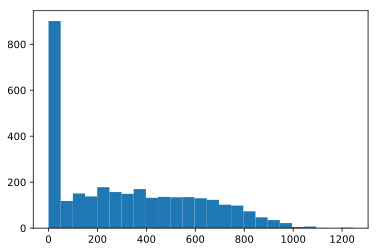

In [19]:
plt.hist(np.diff(np.sort(fault01.eq_list + fault02.eq_list + fault03.eq_list + fault04.eq_list)), bins=25)
plt.show()

This is the most clustered yet, despite the large range of recurrence intervals present.

## Summary

The simple numerical experiments we've done illustrate a few important things:
1. *Very small perturbations to faults can cause earthquake clusters*.  This means that we can't rule out Coulomb stress changes as a cause, despite their miniscule magnitude.
1. *Earthquake clustering is inconsistent with linear stress reloading on faults.* This means that elastic, and therefore linear, models of fault systems will fail to capture important fault interactions. The exact source of nonlinearity (i.e. time or phase dependence of some sort) is still unclear, although viscoelastic relaxation in the lower crust and upper mantle is a likely candidate. Modeling these systems is quite challenging, but needs to be done.
2. *Even faults with very different slip rates can still sometimes rupture synchronously.* Clusters are ubiquitous but not the rule in instrumental and paleoseismic datasets. Very different faults can, and do, talk to each other but it takes very similar faults to march completely in step.
3. *More faults in a region means more clustered seismicity.*  This is a big one especially for hazard analysis--the potential for ongoing seismicity in an area, even with very slow faults, is quite high after an earthquake.

These results are quite encouraging, demonstrating that we can reproduce important seismic phenomena with some simple models, and we can home in on the important factors (nonlinear reloading) and ignore others (recurrence interval discrepancies, the small magnitude of Coulomb stress changes) in continued work on fault interaction and clustering.

As time permits, I will add more and more realistic physics and geology to see how the story plays out.  Stay tuned!